# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [2]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [3]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [4]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [5]:
#Your codei

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [8]:
import tensorflow

Number of images:  800
800


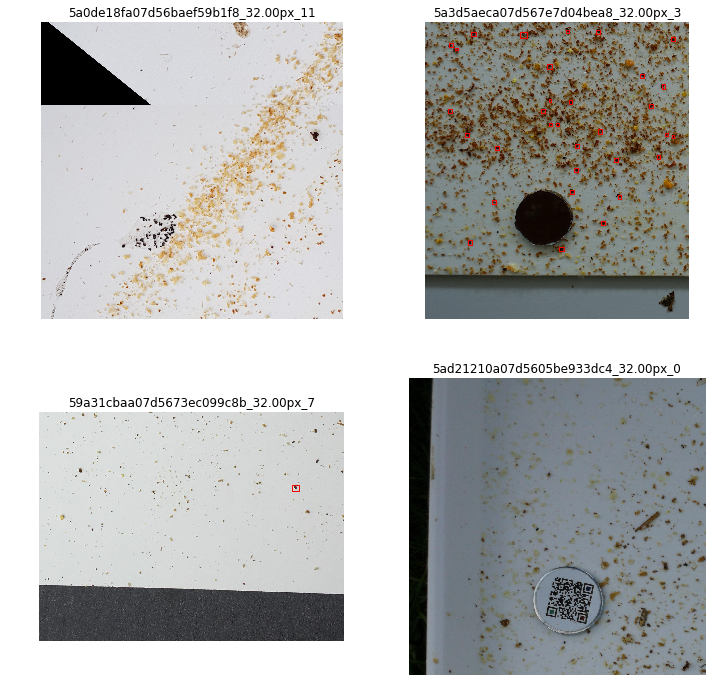

In [143]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gzip
from sklearn.metrics import confusion_matrix

import tarfile
import scipy.io

import skimage.io
import matplotlib.patches as patches

import math
import skimage.color

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)
    
def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)

# **** type = test, train, validation ****
type = "train"

annotations_path = os.path.join(data_base_path, data_folder, "annotations",type)

# Load images
file_ = open(os.path.join(data_base_path, data_folder, type + ".txt"), "r")
im_names = []
name_i = file_.readline()
im_names.append(name_i[0:(len(name_i)-1)])
while (name_i):
    name_i = file_.readline()
    im_names.append(name_i[0:(len(name_i)-1)])

im_names = im_names[0:(len(im_names)-1)]
# for names in im_names:
#     print(names)
    
    
filenames = [os.path.join(data_base_path, data_folder,"images", type, name) + '.jpg' for name in im_names]
test = skimage.io.imread_collection(filenames)
print('Number of images: ', len(test))

import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

annotations_xmls = [parse_file(os.path.join(annotations_path, name) + '.xml') for name in im_names]
print(np.size(annotations_xmls))

# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for a1, ax in zip(range (3,7),axes.ravel()):
    im = test[a1] 
    nm = im_names [a1]
    annotations = annotations_xmls[a1]
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

# generate train set
window_size = 60 #n of side pixels of square window
n_channels = 3
train_size = 20000
n_train_labels = 2
perc = 20 #1/perc*100%

indices = np.random.choice(range(np.shape(annotations_xmls)[0]),train_size//2)

train_images = np.zeros([train_size,window_size*window_size*n_channels])
train_labels = np.zeros([train_size,n_train_labels])

counter_labels = 0
for index, a1 in zip(indices, range(0,train_size//2)):
    
    annotation = annotations_xmls[index];
    train_labels[a1] = [0,1]
    train_labels[a1+train_size//2] = [0,1]

    if counter_labels < train_size/perc and np.shape(annotation)[0] > 0:
        indexaux = np.random.choice(range(np.shape(annotation)[0]),1)[0]
        randx = annotation[indexaux]['bbox'][0] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][2]),1)[0]#the rectangles are in x first then y
        randy = annotation[indexaux]['bbox'][1] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][3]),1)[0]

        lenx=np.shape(test[index])[1]
        leny=np.shape(test[index])[0]
        if randx < 0:
            randx = 0
        if randx + window_size >= lenx:
            randx = lenx - window_size;

        if randy < 0:
            randy = 0
        if randy + window_size >= leny:
            randy = leny - window_size;


        maux = test[index][randy:randy+window_size,randx:randx+window_size,:]
        train_images[a1]= np.ndarray.flatten(maux)
        train_images[a1+train_size//2]=np.ndarray.flatten(maux[:,::-1,:])
        train_labels[a1] = [1,0]
        train_labels[a1+train_size//2] = [1,0]
        counter_labels += 1

    else:
        randx = np.random.choice(range(np.shape(test[index])[1]-window_size),1)[0]
        randy = np.random.choice(range(np.shape(test[index])[0]-window_size),1)[0]
        
        maux = test[index][randy:randy+window_size,randx:randx+window_size,:]
        train_images[a1] = np.ndarray.flatten(maux)
        train_images[a1+train_size//2]=np.ndarray.flatten(maux[:,::-1,:])


        if np.shape(annotation)[0] > 0:
            for ann in annotation:
                if ann['bbox'][1] > randy and ann['bbox'][1]+ann['bbox'][3] < randy+window_size and ann['bbox'][0] > randx and ann['bbox'][0]+ann['bbox'][2] < randx+window_size:
                    counter_labels += 1
                    train_labels[a1] = [1,0]
                    train_labels[a1+train_size//2] = [1,0]
                    break
# generate test images
test_size = 1000
n_test_labels = 2

indices = np.random.choice(range(np.shape(annotations_xmls)[0]),test_size)

test_images = np.zeros([test_size,window_size*window_size*n_channels])
test_labels = np.zeros([test_size,n_test_labels])

counter_labels = 0
for index, a1 in zip(indices, range(0,test_size)):
    
    annotation = annotations_xmls[index];
    test_labels[a1] = [0,1]

    if counter_labels < test_size/perc and np.shape(annotation)[0] > 0:
        indexaux = np.random.choice(range(np.shape(annotation)[0]),1)[0]
        randx = annotation[indexaux]['bbox'][0] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][2]),1)[0]#the rectangles are in x first then y
        randy = annotation[indexaux]['bbox'][1] - np.random.choice(range(window_size-annotation[indexaux]['bbox'][3]),1)[0]

        lenx=np.shape(test[index])[1]
        leny=np.shape(test[index])[0]
        if randx < 0:
            randx = 0
        if randx + window_size >= lenx:
            randx = lenx - window_size;

        if randy < 0:
            randy = 0
        if randy + window_size >= leny:
            randy = leny - window_size;


        test_images[a1]= np.ndarray.flatten(test[index][randy:randy+window_size,randx:randx+window_size,:])
        test_labels[a1] = [1,0]
        counter_labels += 1

    else:
        randx = np.random.choice(range(np.shape(test[index])[1]-window_size),1)[0]
        randy = np.random.choice(range(np.shape(test[index])[0]-window_size),1)[0]
        test_images[a1] = np.ndarray.flatten(test[index][randy:randy+window_size,randx:randx+window_size,:])

        if np.shape(annotation)[0] > 0:
            for ann in annotation:
                if ann['bbox'][1] > randy and ann['bbox'][1]+ann['bbox'][3] < randy+window_size and ann['bbox'][0] > randx and ann['bbox'][0]+ann['bbox'][2] < randx+window_size:
                    counter_labels += 1
                    test_labels[a1] = [1,0]
                    break


In [4]:
maxx = 0
maxy = 0
for annotations in annotations_xmls:
    # Iterate over annotations
    for anno in annotations:
        if maxx < anno['bbox'][2]:
            maxx = anno['bbox'][2]
        if maxy < anno['bbox'][3]:
            maxy = anno['bbox'][3]

print(maxx, maxy)
        

56 52


In [28]:
# Display the openend files
# image_shape = (28, 28)
train_set_size = 50
# test_set_size = 10000

#Define the number of nodes for the hidden layers
hidden_nodes_1=256
hidden_nodes_2=512
batch_size = 25
# hidden_nodes_1=256
# hidden_nodes_2=512
# batch_size = 50

num_labels = 2
ndiv = 2 #n for dividing and sliding the window
n_labels = 2


MLP_GRAPH = tf.Graph()

with MLP_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
#     TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
    TF_TEST_DATASET = tf.cast(tf.constant(test_images), tf.float32)

    """
       The first hidden layer with 1024 nodes
    """
    
    with tf.name_scope("FirstHidden"):
        """
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[window_size * window_size*n_channels, hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
        
    """
       The second hidden layer with 512 nodes
    """
    
    with tf.name_scope("SecondHidden"):
        """
            Same as the first hidden layer, but modifying the size of the layer
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_2=tf.Variable(tf.random_normal(shape=[hidden_nodes_1,hidden_nodes_2], stddev=0.1))
        HIDDEN_BIASES_2 =tf.Variable(tf.random_normal(shape=[hidden_nodes_2], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)
        TEST_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)       


    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_2, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_2, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_2, WEIGHTS) + BIASES

        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(LOSS)
        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def optimize(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """
#             print(counter_labels)
#             FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS, TF_TEST_DATASET: BATCH_DATA}
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
            
            if acc > 99:
                acc=accuracy(TEST_PREDICTION.eval(), test_labels)
                maxa = max(maxa,acc)
                print("Test accuracy: ", acc)
#                 break
        
            if(step % 50 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                print("Minibatch accuracy: ", acc)
            
            if (step == num_iterations - 1):
                acc=accuracy(TEST_PREDICTION.eval(), test_labels)
                maxa = max(maxa,acc)
                print("Test accuracy: ", acc)

    return acc, maxa

In [12]:
TRAINING_SIZES = [500, 1000, 2000]

#Add your code here

accs = np.zeros(3);
print("Accuracy "," :",optimize(2000,TRAINING_SIZES[2]))

# for a1 in TRAINING_SIZES:
#     print("Accuracy ",a1," :",optimize(500,a1))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Variables initialized
Minibatch loss at step  0 :  782.5026
Minibatch accuracy:  60.0
Minibatch loss at step  50 :  52.88425
Minibatch accuracy:  83.33333333333333
Test accuracy:  91.9
Test accuracy:  92.6
Minibatch loss at step  100 :  3.1420524
Minibatch accuracy:  96.66666666666667
Test accuracy:  92.2
Minibatch loss at step  150 :  30.952099
Minibatch accuracy:  93.33333333333333
Test accuracy:  91.2
Test accuracy:  90.1
Minibatch loss at step  200 :  13.127206
Minibatch accuracy:  96.66666666666667
Test accuracy:  92.9
Test accuracy:  92.1
Minibatch loss at step  250 :  16.379679
Minibatch accuracy:  96.66666666666667
Test accuracy:  93.3
Test accuracy:  94.0
Test accuracy:  93.6
Test accuracy:  91.7
Test accuracy:  91.7
Test accuracy:  93.7
Test accuracy:  93.7
Test accuracy:  93.5
Test accuracy:  93.4
Minibatch loss at step  300 :  34.617504
Minibatch accuracy:  90.0
Minibatch loss at step  350 :  9.130179

Test accuracy:  91.0
Test accuracy:  92.2
Test accuracy:  92.2
Test accuracy:  93.1
Test accuracy:  93.1
Test accuracy:  93.1
Test accuracy:  92.7
Test accuracy:  92.7
Accuracy   : (92.7, 94.5)


In [13]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17336625479419577082
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1462163865
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9889770922195490668
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


Seems to be that the best size for the batch is around 50, 25 is overfitting and 100 is not properly converging


In [19]:
precisions = np.linspace(0.000020, 0.000005,5)
KBS = 50
offs = 5
batch_sizes = [KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs]

print(np.size(precisions))
maxs = np.zeros([np.size(precisions),np.size(batch_sizes)])

for bs , a1 in zip(batch_sizes,range(np.size(batch_sizes))):
    for prec, a2 in zip(precisions,range(np.size(precisions))) :

        #Define the number of nodes for the hidden layers
        hidden_nodes_1=256
        hidden_nodes_2=256
        hidden_nodes_3=512
        batch_size = bs

        num_labels = 2
        ndiv = 2 #n for dividing and sliding the window
        n_labels = 2


        CNN_GRAPH = tf.Graph()

        with CNN_GRAPH.as_default():
            """
                For the training data we use place holders in order to feed them
                in the run time with those mini bitches :D
            """
            TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
            TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
        #     TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
            TF_TEST_DATASET = tf.cast(tf.constant(test_images), tf.float32)

            """
               The first hidden layer with 1024 nodes
            """

            with tf.name_scope("FirstHidden"):
                """
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[window_size * window_size*n_channels, hidden_nodes_1], stddev=0.1))
                HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
                TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(TF_TEST_DATASET, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

            """
               The second hidden layer with 512 nodes
            """

            with tf.name_scope("SecondHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_2=tf.Variable(tf.random_normal(shape=[hidden_nodes_1,hidden_nodes_2], stddev=0.1))
                HIDDEN_BIASES_2 =tf.Variable(tf.random_normal(shape=[hidden_nodes_2], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)
                TEST_HIDDEN_LOGITS_2 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_1, HIDDEN_WEIGHTS_2) + HIDDEN_BIASES_2)       

            with tf.name_scope("ThirdHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_3=tf.Variable(tf.random_normal(shape=[hidden_nodes_2,hidden_nodes_3], stddev=0.1))
                HIDDEN_BIASES_3 =tf.Variable(tf.random_normal(shape=[hidden_nodes_3], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_3 = tf.nn.relu(tf.matmul(TRAIN_HIDDEN_LOGITS_2, HIDDEN_WEIGHTS_3) + HIDDEN_BIASES_3)
                TEST_HIDDEN_LOGITS_3 = tf.nn.relu(tf.matmul(TEST_HIDDEN_LOGITS_2, HIDDEN_WEIGHTS_3) + HIDDEN_BIASES_3)

            with tf.name_scope("Softmax-Linear"):
                """
                    Initialize the main weights and biases
                """
                WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_3, num_labels], stddev=0.1))
                BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

                """
                    Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
                """
                TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_3, WEIGHTS) + BIASES
                TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_3, WEIGHTS) + BIASES

                LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

                OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
                tf.add_to_collection("activation", TRAIN_LOGITS)

                TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
                TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
                
        accx, maxs[a2,a1] = optimize2(2000,TRAINING_SIZES[2])
        
        print("Accuracy "," :",accx)
                     
print (maxs)

10
Variables initialized
Minibatch loss at step  0 :  1180.4807
Minibatch accuracy:  50.0
Minibatch loss at step  50 :  51.975388
Minibatch accuracy:  83.33333333333333
Test accuracy:  89.9
Test accuracy:  91.1
Test accuracy:  87.0
Minibatch loss at step  100 :  53.662704
Minibatch accuracy:  86.66666666666667
Test accuracy:  89.9
Minibatch loss at step  150 :  19.891901
Minibatch accuracy:  96.66666666666667
Minibatch loss at step  200 :  20.674696
Minibatch accuracy:  83.33333333333333
Minibatch loss at step  250 :  9.902209
Minibatch accuracy:  96.66666666666667
Test accuracy:  90.8
Test accuracy:  89.8
Test accuracy:  90.0
Test accuracy:  89.9
Test accuracy:  92.1
Test accuracy:  91.5
Test accuracy:  91.5
Test accuracy:  92.0
Minibatch loss at step  300 :  8.233305
Minibatch accuracy:  96.66666666666667
Test accuracy:  90.6
Test accuracy:  91.4
Test accuracy:  93.1
Test accuracy:  88.9
Minibatch loss at step  350 :  19.765455
Minibatch accuracy:  83.33333333333333
Test accuracy:  9

KeyboardInterrupt: 

In [16]:
print(maxs)
print(precisions[5])

[[95.2 94.8 92.9 92.5 94.7]
 [94.4 94.1 94.5 94.5 92.8]
 [93.8 93.7 94.9 93.4 94.4]
 [94.2 93.1 94.2 93.8 93.8]
 [94.8 93.5 95.1 94.6 92.4]
 [96.2 95.  94.3 94.3 93.9]
 [94.4 93.2 94.7 93.3 93.7]
 [93.7 94.6 95.3 93.5 92.9]
 [93.5 92.9 95.1 93.4 94.4]
 [94.9 93.4 94.1 93.8 93.4]]
1.1666666666666668e-05


The more efficient batch size and learning rate are 50 and 1.166E-5.
Next step is to try to improve by feeding back false positives

# CNN
Tunning

In [144]:
TRAINING_SIZES = [5000, 10000, 20000]
def optimizeCNN(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=CNN_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """
#             print(counter_labels)
#             FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS, TF_TEST_DATASET: BATCH_DATA}
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            FEED_DICT_TEST = {TF_TRAIN_DATASET: test_images, TF_TRAIN_LABELS: test_labels}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
            
#             if acc > 99:
#                 acc=accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
#                 maxa = max(maxa,acc)
#                 print("Test accuracy: ", acc)
#                 break
        
            if(step % 500 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                acc2 = accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
                print("Minibatch accuracy: ", acc," test acc: ", acc2) 
            
            if (step == num_iterations - 1):
                acc2=accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
                maxa = max(maxa,acc2)
                print("Test accuracy: ", acc2)

    return acc, acc2

precisions = np.linspace(0.00050, 0.0001,5)
KBS = 50
offs = 2
batch_sizes = [KBS-3*offs,KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs,KBS+3*offs]
# batch_sizes = [KBS-2*offs,KBS-offs,KBS,KBS+offs,KBS+2*offs]
# batch_sizes = [KBS-offs,KBS,KBS+offs]

print(np.size(precisions), np.shape(test_images))
maxs = np.zeros([np.size(precisions),np.size(batch_sizes)])

for bs , a1 in zip(batch_sizes,range(np.size(batch_sizes))):
    for prec, a2 in zip(precisions,range(np.size(precisions))) :

        #Define the number of nodes for the hidden layers
        hidden_nodes_1=256
        hidden_nodes_2=256
        hidden_nodes_3=512
        batch_size = bs

        num_labels = 2
        ndiv = 2 #n for dividing and sliding the window
        n_labels = 2
        
        #parameters of convolutional layer
        conv1_fmaps = 32
        conv1_ksize = 2
        conv1_stride = 1
        conv1_pad = "SAME"

        conv2_fmaps = 64
        conv2_ksize = 2
        conv2_stride = 2
        conv2_pad = "SAME"
        pool2_fmaps = conv2_fmaps*225

        CNN_GRAPH = tf.Graph()

        with CNN_GRAPH.as_default():
            """
                For the training data we use place holders in order to feed them
                in the run time with those mini bitches :D
            """
            TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size*window_size*n_channels))
            TF_TRAIN_DATASET_RESHAPED = tf.reshape(TF_TRAIN_DATASET,  shape=[-1,window_size,window_size, n_channels])
            TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
        #     TF_TEST_DATASET = tf.placeholder(tf.float32, shape=(None, window_size * window_size*n_channels))
#             TF_TEST_DATASET = tf.cast(tf.constant(np.reshape(test_images, (np.shape(test_images)[0], window_size, window_size, n_channels))), tf.float32)
#             TF_TEST_DATASET0 = tf.reshape(test_images, shape=[None, window_size, window_size, n_channels])
#             TF_TEST_DATASET = tf.cast(tf.reshape(tf.constant(test_images), shape=[None, window_size, window_size, n_channels]), tf.float32)
#             TF_TEST_DATASET = tf.cast(tf.constant(tf.reshape(tf.convert_to_tensor(test_images), shape=[np.shape(test_images)[0], window_size, window_size, n_channels])), tf.float32)
#             TF_TEST_DATASET0 = tf.reshape(tf.convert_to_tensor(test_images), shape=[np.shape(test_images)[0], window_size, window_size, n_channels])
#             TF_TEST_DATASET0 = tf.convert_to_tensor(test_images,dtype="float32")
            TF_TEST_DATASET0 = tf.constant(test_images,dtype="float32")
            TF_TEST_DATASET = tf.reshape(TF_TEST_DATASET0, shape=[-1, window_size, window_size, n_channels])
            """
               The first hidden layer with 1024 nodes
            """
            with tf.name_scope("FirstConvPool"):
                #train
                train_conv1 = tf.layers.conv2d(TF_TRAIN_DATASET_RESHAPED, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                         strides = conv1_stride, padding=conv1_pad,
                                         activation = tf.nn.relu, name="train_conv1")
#                 train_pool1 = tf.nn.max_pool(train_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                
                #test
                test_conv1 = tf.layers.conv2d(TF_TEST_DATASET, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                         strides = conv1_stride, padding=conv1_pad,
                                         activation = tf.nn.relu, name="test_conv1")
#                 test_pool1 = tf.nn.max_pool(test_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                
            with tf.name_scope("SecondConvPool"):
                train_conv2 = tf.layers.conv2d(train_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                         strides=conv2_stride, padding=conv2_pad,
                                         activation=tf.nn.relu, name="train_conv2")
                train_pool2 = tf.nn.max_pool(train_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                train_pool2_flat = tf.reshape(train_pool2, shape=[-1,pool2_fmaps])
            
                test_conv2 = tf.layers.conv2d(test_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                         strides=conv2_stride, padding=conv2_pad,
                                         activation=tf.nn.relu, name="test_conv2")
                test_pool2 = tf.nn.max_pool(test_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
                test_pool2_flat = tf.reshape(test_pool2, shape=[-1,pool2_fmaps])  

   

            with tf.name_scope("FirstHidden"):
                """
                    Same as the first hidden layer, but modifying the size of the layer
                    Initialize the hidden weights and biases
                """
                HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[pool2_fmaps,hidden_nodes_1], stddev=0.1))
                HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

                """
                    Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
                    The relu is applied on the hidden layer nodes only
                """
                TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(train_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)
                TEST_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(test_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

            with tf.name_scope("Softmax-Linear"):
                """
                    Initialize the main weights and biases
                """
                WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_1, num_labels], stddev=0.1))
                BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

                """
                    Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
                """
                TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_1, WEIGHTS) + BIASES
                TEST_LOGITS = tf.matmul(TEST_HIDDEN_LOGITS_1, WEIGHTS) + BIASES

                LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

#                 OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
                OPTIMIZER = tf.train.AdamOptimizer(learning_rate=prec).minimize(LOSS)
    
                tf.add_to_collection("activation", TRAIN_LOGITS)


                TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
                TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
                
        accx, maxs[a2,a1] = optimizeCNN(2001,TRAINING_SIZES[2])
        
        print("Accuracy "," :",accx)
                     
print (maxs)

5 (1000, 10800)
Variables initialized
Minibatch loss at step  0 :  16.875227
Minibatch accuracy:  90.9090909090909  test acc:  6.4
Minibatch loss at step  500 :  0.51157176
Minibatch accuracy:  93.18181818181819  test acc:  94.4
Minibatch loss at step  1000 :  0.33176252
Minibatch accuracy:  93.18181818181819  test acc:  95.1
Minibatch loss at step  1500 :  0.24046515
Minibatch accuracy:  95.45454545454545  test acc:  96.4
Minibatch loss at step  2000 :  0.094725795
Minibatch accuracy:  97.72727272727273  test acc:  96.4
Test accuracy:  96.4
Accuracy   : 97.72727272727273
Variables initialized
Minibatch loss at step  0 :  38.27603
Minibatch accuracy:  86.36363636363636  test acc:  6.4
Minibatch loss at step  500 :  0.102207705
Minibatch accuracy:  97.72727272727273  test acc:  95.3
Minibatch loss at step  1000 :  0.58528155
Minibatch accuracy:  93.18181818181819  test acc:  96.9
Minibatch loss at step  1500 :  0.24975142
Minibatch accuracy:  95.45454545454545  test acc:  96.3
Minibatch

Variables initialized
Minibatch loss at step  0 :  20.99177
Minibatch accuracy:  90.0  test acc:  5.4
Minibatch loss at step  500 :  1.3273841e-05
Minibatch accuracy:  100.0  test acc:  95.7
Minibatch loss at step  1000 :  0.6068545
Minibatch accuracy:  94.0  test acc:  96.6
Minibatch loss at step  1500 :  0.07465022
Minibatch accuracy:  98.0  test acc:  96.2
Minibatch loss at step  2000 :  0.08891624
Minibatch accuracy:  96.0  test acc:  97.9
Test accuracy:  97.9
Accuracy   : 96.0
Variables initialized
Minibatch loss at step  0 :  127.32491
Minibatch accuracy:  86.0  test acc:  7.0
Minibatch loss at step  500 :  3.3361444
Minibatch accuracy:  92.0  test acc:  96.6
Minibatch loss at step  1000 :  1.0405083
Minibatch accuracy:  96.0  test acc:  95.8
Minibatch loss at step  1500 :  0.27855757
Minibatch accuracy:  96.0  test acc:  96.6
Minibatch loss at step  2000 :  0.4107674
Minibatch accuracy:  98.0  test acc:  96.5
Test accuracy:  96.5
Accuracy   : 98.0
Variables initialized
Minibatch

Minibatch loss at step  1500 :  0.31955174
Minibatch accuracy:  92.85714285714286  test acc:  97.5
Minibatch loss at step  2000 :  0.10004904
Minibatch accuracy:  98.21428571428571  test acc:  97.2
Test accuracy:  97.2
Accuracy   : 98.21428571428571
Variables initialized
Minibatch loss at step  0 :  46.17767
Minibatch accuracy:  83.92857142857143  test acc:  6.3
Minibatch loss at step  500 :  0.27455002
Minibatch accuracy:  92.85714285714286  test acc:  96.0
Minibatch loss at step  1000 :  0.26906773
Minibatch accuracy:  96.42857142857143  test acc:  93.6
Minibatch loss at step  1500 :  0.61744946
Minibatch accuracy:  92.85714285714286  test acc:  94.7
Minibatch loss at step  2000 :  0.34967825
Minibatch accuracy:  94.64285714285714  test acc:  97.0
Test accuracy:  97.0
Accuracy   : 94.64285714285714
Variables initialized
Minibatch loss at step  0 :  5.7566757
Minibatch accuracy:  85.71428571428571  test acc:  24.4
Minibatch loss at step  500 :  0.32610455
Minibatch accuracy:  98.21428

Already tunned

In [110]:
print(precisions[8])

0.00014444444444444444


In [145]:
TRAINING_SIZES = [5000, 10000, 20000]
def optimizeCNN(num_iterations, num_samples):
    counter_labels = 0
    maxa = 0
    
    with tf.Session(graph=CNN_GRAPH) as session:

        """
            Start the above variable initialization
        """
        tf.initialize_all_variables().run()
        print("Variables initialized")
        

        for step in range(num_iterations):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = train_images[:num_samples]
            TRAIN_LABELS_S = train_labels[:num_samples]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(np.shape(train_labels)[0]
                                             ), batch_size)
            BATCH_DATA = train_images[indices, :]
            BATCH_LABELS = train_labels[indices, :]

            """
                Feed the current session with batch data
            """

            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            FEED_DICT_TEST = {TF_TRAIN_DATASET: test_images, TF_TRAIN_LABELS: test_labels}
            _, l, predictions = session.run([OPTIMIZER, LOSS, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            acc = accuracy(predictions, BATCH_LABELS)
            acc2 = accuracy(TRAIN_PREDICTION.eval(feed_dict=FEED_DICT_TEST), test_labels)
            if (maxa < acc2):
                maxa = acc2
#                 print("Test accuracy: ", acc2)
                saved_path = saver.save(session, './my-model-max-20')
        
            if(step % 500 == 0):
                print("Minibatch loss at step ", step, ": ", l)
                print("Minibatch accuracy: ", acc," test acc: ", acc2) 
            
            if (step == num_iterations - 1):
                maxa = max(maxa,acc2)
                print("Test accuracy: ", acc2)
                
        saved_path = saver.save(session, './my-model-20')
        print('model saved in {}'.format(saved_path))

    return acc, acc2

bs = 56
prec = 0.00014444444444444444

#Define the number of nodes for the hidden layers
hidden_nodes_1=256
hidden_nodes_2=256
hidden_nodes_3=512
batch_size = bs

num_labels = 2
ndiv = 2 #n for dividing and sliding the window
n_labels = 2

#parameters of convolutional layer
conv1_fmaps = 32
conv1_ksize = 2
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 2
conv2_stride = 2
conv2_pad = "SAME"
pool2_fmaps = conv2_fmaps*225

CNN_GRAPH = tf.Graph()

with CNN_GRAPH.as_default():
    """
        For the training data we use place holders in order to feed them
        in the run time with those mini bitches :D
    """
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, window_size*window_size*n_channels))
    TF_TRAIN_DATASET_RESHAPED = tf.reshape(TF_TRAIN_DATASET,  shape=[-1,window_size,window_size, n_channels])
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, num_labels))
    """
       The first hidden layer with 1024 nodes
    """
    with tf.name_scope("FirstConvPool"):
        #train
        train_conv1 = tf.layers.conv2d(TF_TRAIN_DATASET_RESHAPED, filters=conv1_fmaps, kernel_size = conv1_ksize,
                                 strides = conv1_stride, padding=conv1_pad,
                                 activation = tf.nn.relu, name="train_conv1")

    with tf.name_scope("SecondConvPool"):
        train_conv2 = tf.layers.conv2d(train_conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                                 strides=conv2_stride, padding=conv2_pad,
                                 activation=tf.nn.relu, name="train_conv2")
        train_pool2 = tf.nn.max_pool(train_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        train_pool2_flat = tf.reshape(train_pool2, shape=[-1,pool2_fmaps])


    with tf.name_scope("FirstHidden"):
        """
            Same as the first hidden layer, but modifying the size of the layer
            Initialize the hidden weights and biases
        """
        HIDDEN_WEIGHTS_1=tf.Variable(tf.random_normal(shape=[pool2_fmaps,hidden_nodes_1], stddev=0.1))
        HIDDEN_BIASES_1 =tf.Variable(tf.random_normal(shape=[hidden_nodes_1], stddev=0.1))

        """
            Compute the logits WX + b and then apply D(S(WX + b), L) on them for the hidden layer
            The relu is applied on the hidden layer nodes only
        """
        TRAIN_HIDDEN_LOGITS_1 = tf.nn.relu(tf.matmul(train_pool2_flat, HIDDEN_WEIGHTS_1) + HIDDEN_BIASES_1)

    with tf.name_scope("Softmax-Linear"):
        """
            Initialize the main weights and biases
        """
        WEIGHTS=tf.Variable(tf.random_normal(shape=[hidden_nodes_1, num_labels], stddev=0.1))
        BIASES=tf.Variable(tf.random_normal(shape=[num_labels], stddev=0.1))

        """
            Compute the logits WX + b and the apply D(S(WX + b), L) on them for the final layer
        """
        TRAIN_LOGITS = tf.matmul(TRAIN_HIDDEN_LOGITS_1, WEIGHTS) + BIASES
        LOSS = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS))

#       OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=prec).minimize(LOSS)
        OPTIMIZER = tf.train.AdamOptimizer(learning_rate=prec).minimize(LOSS)

        tf.add_to_collection("activation", TRAIN_LOGITS)

        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        
        saver = tf.train.Saver()

accx,acc_test = optimizeCNN(2001,TRAINING_SIZES[2])

print("Accuracy batch"," : ",accx," Accuracy test"," : ",acc_test)
                     

Variables initialized
Minibatch loss at step  0 :  61.48106
Minibatch accuracy:  91.07142857142857  test acc:  94.5
Minibatch loss at step  500 :  3.4746935
Minibatch accuracy:  92.85714285714286  test acc:  96.6
Minibatch loss at step  1000 :  0.3408181
Minibatch accuracy:  96.42857142857143  test acc:  95.5
Minibatch loss at step  1500 :  0.5211991
Minibatch accuracy:  98.21428571428571  test acc:  95.5
Minibatch loss at step  2000 :  0.59218615
Minibatch accuracy:  94.64285714285714  test acc:  96.1
Test accuracy:  96.1
model saved in ./my-model-20
Accuracy batch  :  94.64285714285714  Accuracy test  :  96.1


In [148]:
def detect_by_cnn(img):

    #Let's suppose that the size of the window is constant at 50x50
    win_size = 60
    count = 0
    # 3. slide the window
    [x_len,y_len,_] = np.shape(img)
    with tf.Session(graph=CNN_GRAPH) as session:
        # Restore variables from disk.
        imported_graph.restore(session, './my-model-20')
#         print("Model restored.")
        for i in range(int(np.ceil(x_len/win_size))):
            for j in range(int(np.ceil(y_len/win_size))):
                #One window on the image
                indx = win_size*i
                indy = win_size*j
                if (indx+win_size>=x_len):
                    indx = x_len-win_size
                if (indy+win_size>=y_len):
                    indy = y_len-win_size
                window = img[indx:indx+win_size, indy:indy+win_size, :]   
            
#                 print(np.shape([np.ndarray.flatten(window)]),np.shape([[0,1]]))
                FEED_DICT_TEST = {TF_TRAIN_DATASET: [np.ndarray.flatten(window)], TF_TRAIN_LABELS: [[0,1]]}
#                 print(TRAIN_PREDICTION.eval(session=session,feed_dict=FEED_DICT_TEST)[0])
#                 print(TRAIN_PREDICTION.eval(session=session,feed_dict=FEED_DICT_TEST))
                aux = TRAIN_PREDICTION.eval(session=session,feed_dict=FEED_DICT_TEST)[0]
                if aux[0] == 1.00:
                    count+=1
#                     print(aux[1])
#                     fig, ax = plt.subplots(1, 1, figsize=(12, 3))
#                     ax.imshow(window) #, cmap='gray'
#                     ax.axis('off')
#             ax.plot(contour_win[:,0], contour_win[:,1], '-b', lw=3)
#             ax.set_xticks([]), ax.set_yticks([])
    return count
n=26
for n in range(0,50):
    c = detect_by_cnn(test[n])
    print(c,np.shape(annotations_xmls[n])[0])

INFO:tensorflow:Restoring parameters from ./my-model-2000
0 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
93 26
INFO:tensorflow:Restoring parameters from ./my-model-2000
37 3
INFO:tensorflow:Restoring parameters from ./my-model-2000
11 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
129 32
INFO:tensorflow:Restoring parameters from ./my-model-2000
2 1
INFO:tensorflow:Restoring parameters from ./my-model-2000
12 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
4 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
87 8
INFO:tensorflow:Restoring parameters from ./my-model-2000
3 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
57 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
304 5
INFO:tensorflow:Restoring parameters from ./my-model-2000
7 1
INFO:tensorflow:Restoring parameters from ./my-model-2000
0 0
INFO:tensorflow:Restoring parameters from ./my-model-2000
112 75
INFO:tensorflow:Restoring parameters from ./my-model-20

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [45]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code